In [1]:
import sys
import math
import numpy as np
from random import getrandbits,uniform,random,randint
from matplotlib import pyplot as plt

# 点坐标生成模块
from CityGenerator import CoordinateProcess

In [2]:
# 遗传算法
class GeneticTsp:
    def __init__(self,city_coord, distance_matrix,chrmsome_size=20,cross_prob=1,mutate_prob=1,iter_round=100,
                mutate_percentage=0.2
                 ):
        self.city_coord = city_coord  # 城市坐标
        self.distance_matrix = distance_matrix  # 距离矩阵
        self.chrmsome_size = chrmsome_size  # 染色体条数
        self.iter_round = iter_round # 迭代进化次数
        
        self.cross_prob = cross_prob  # 交叉概率，即能产生新后代的概率
        self.mutate_prob = mutate_prob  # 染色体变异概率
        self.mutate_percentage = mutate_percentage  # 染色体基因变异的比例
        
        self.individual_list = [self.encode() for _ in range(self.chrmsome_size)]  # 种群染色体集合
        self.individual_fitness_list = self.evaluate_fitness(self.individual_list)  # 计算种群中所有个体初始的适应度

        self.new_individual_list = []  # 新一代染色体集合
        self.new_individual_fitness_list = []  # 新一代染色体适应度集合
        
        self.best_chrmsome = self.individual_list[np.argmax(self.individual_fitness_list)]  # 最优染色体
        self.best_plength = self.__evaluate_distance(self.best_chrmsome)
        self.best_fitness = np.max(self.individual_fitness_list)
    
        self.mean_fitness_iter = []
        self.best_fitness_iter = []
        self.best_solution_iter = []
        
    # 产生随机染色体
    def encode(self):
        init_chrmsome = [i for i in range(len(self.city_coord))]
        np.random.shuffle(init_chrmsome)
        return init_chrmsome
    
    # 计算路径的长度
    def  __evaluate_distance(self, indv_chrsm):
        path_distance = 0
        for index in range(len(indv_chrsm)-1):
            path_distance += self.distance_matrix[indv_chrsm[index]][indv_chrsm[index + 1]]
        path_distance += self.distance_matrix[indv_chrsm[0]][indv_chrsm[-1]]
        return  path_distance
    
    # 计算种群中所有个体的适应度,适应度计算为路径距离的倒数*100
    def evaluate_fitness(self, individual_list):
        res_fitness_list = []
        for index in range(len(individual_list)):
            indv_chrsm = individual_list[index]
            res_fitness_list.append(100/self.__evaluate_distance(indv_chrsm))
        return res_fitness_list
    
    # 轮盘对赌选择一条染色体
    def __roulette_selection(self, fitness_list):  
        val_list = np.array(fitness_list)
        sumFits = val_list.sum()
        rndPoint = uniform(0, sumFits)
        accumulator = 0.0
        for ind, val in enumerate(val_list):
            accumulator += val
            if accumulator >= rndPoint:
                return ind
            
    # 轮盘对赌染色体选择
    def roulette_selection(self, fitness_list):
        chrsome_p1 = self.__roulette_selection(fitness_list)
        chrsome_p2 = self.__roulette_selection(fitness_list)
        while True:
            if chrsome_p1 != chrsome_p2:
                break
            chrsome_p2 = self.__roulette_selection(fitness_list)
        return chrsome_p1,chrsome_p2
    
    # 停止运行控制
    def stop_control(self, iter_round):
        return iter_round >= self.iter_round
    
    # 交叉
    def cross(self, chrmsome_p1, chrmsome_p2):
        rnd_point = uniform(0, 1)
        if rnd_point > self.cross_prob:
            # 产生两个随机数，代表染色体截点
            rand_points = np.random.randint(0, high=len(city_coord),size=2)
            start_pos = rand_points.min()
            end_pos = rand_points.max()
            selected_part_p1 = chrmsome_p1[start_pos:end_pos]  
            selected_part_p2 = chrmsome_p2[start_pos:end_pos]
        
            cp_chrmsome_p1 = chrmsome_p1.copy()
            cp_chrmsome_p2 = chrmsome_p2.copy()
            # 清除重复的点
            for index in range(len(cp_chrmsome_p1)):
                if cp_chrmsome_p1[index] in selected_part_p2:
                    chrmsome_p1.remove(cp_chrmsome_p1[index])
                if cp_chrmsome_p2[index] in selected_part_p1:
                    chrmsome_p2.remove(cp_chrmsome_p2[index])
            rand_insert_point = np.random.randint(0, high=len(chrmsome_p1))
            chrmsome_p1 = chrmsome_p1[:rand_insert_point] + selected_part_p2 + chrmsome_p1[rand_insert_point:]
            chrmsome_p2 = chrmsome_p2[:rand_insert_point] + selected_part_p1 + chrmsome_p2[rand_insert_point:]
        return  chrmsome_p1, chrmsome_p2
       
    # 变异
    def mutate(self, chrmsome_p):
        rnd_point = uniform(0, 1)
        mutate_num = round(self.mutate_percentage * len(chrmsome_p))
        if rnd_point >= self.mutate_prob:
            mutate_count = 0
            while True:
                if mutate_count >= mutate_num:
                    break
                trans_points = np.random.randint(0, len(chrmsome_p),size=2)
                start_pos = trans_points.min()
                end_pos = trans_points.max()
                chrmsome_p[start_pos],chrmsome_p[end_pos] = chrmsome_p[end_pos],chrmsome_p[start_pos]
                mutate_count += 1
        return chrmsome_p
    
    # 自然选择，优胜劣汰
    def natural_select(self):
        range_len = len(self.new_individual_list)
        while True:
            # 找到新子代中适应度最高的染色体 index
            newindividual_highest_fitness_index = np.argmax(self.new_individual_fitness_list)
            # 找到旧种群中适应度最低的染色体 index
            individual_lowest_fitness_index = np.argmin(self.individual_fitness_list)
            if self.new_individual_fitness_list[newindividual_highest_fitness_index] > self.individual_fitness_list[individual_lowest_fitness_index]:
                # 个体替代
                self.individual_list[individual_lowest_fitness_index] = self.new_individual_list[newindividual_highest_fitness_index]
                self.individual_fitness_list[individual_lowest_fitness_index] = self.new_individual_fitness_list[newindividual_highest_fitness_index]
                # 删除新子代中适应度最高的染色体
                self.new_individual_fitness_list.pop(newindividual_highest_fitness_index)
                self.new_individual_list.pop(newindividual_highest_fitness_index)
            else:
                break
        return
    
    # 更新最优染色体
    def refresh_best_chromosome(self):  
        best_index = np.argmax(self.individual_fitness_list)
        self.best_chrmsome = self.individual_list[best_index]
        self.best_fitness = self.individual_fitness_list[best_index]
        self.best_plength = self.__evaluate_distance(self.best_chrmsome)
    #  进行一次进化过程
    def evolve(self): 
        pos_generation = 0
        # 初始化子代种群染色体集合
        self.new_individual_list = []
        self.new_individual_fitness_list = []
        while True:
            # 选择两个染色体
            chrmsome_index_1, chrmsome_index_2 = self.roulette_selection(self.individual_fitness_list)
            # 交叉
            new_individual_p1,new_individual_p2 = self.cross(self.individual_list[chrmsome_index_1].copy(),
                                                             self.individual_list[chrmsome_index_2].copy())
            # 变异
            new_individual_p1 = self.mutate(new_individual_p1)
            new_individual_p2 = self.mutate(new_individual_p2)
            # 存放在新个体集合中
            self.new_individual_list.extend([new_individual_p1, new_individual_p2])
            if pos_generation > self.chrmsome_size/2:
                break
            pos_generation += 2
        # 计算子代染色体适应度
        self.new_individual_fitness_list = self.evaluate_fitness(self.new_individual_list)
        # 更新换代，用新子代最好的去替代旧种群中最差的
        self.natural_select()
        # 更新全局最优个体
        self.refresh_best_chromosome()
    #  绘图
    def plot_iter(self):
        x = [iter_i for iter_i in range(1,len(self.mean_fitness_iter)+1)]
        y_list = [self.mean_fitness_iter, self.best_fitness_iter, self.best_solution_iter]
        y_lable_list = ['mean_fitness','best_fitness','shortest_length']
        for y_index in range(len(y_list)):
            plt.plot(x, y_list[y_index],label=y_lable_list[y_index])
            plt.xlabel(r'iter_round')
            plt.ylabel(y_lable_list[y_index])
            plt.show()
    # 绘制最优路径图
    def plot_path(self):
        plt.title("City Coordinate")
        plt.xlabel("x")
        plt.ylabel("y")
        plt.scatter(self.city_coord[:, 0], self.city_coord[:, 1])
        for i in range(self.city_coord.shape[0]):
            plt.annotate(str(i), xy=(self.city_coord[i][0],
                                     self.city_coord[i][1]
                                     ))
        line_x = [self.city_coord[i, 0] for i in self.best_chrmsome]
        line_y = [self.city_coord[i, 1] for i in self.best_chrmsome]
        plt.annotate('start_end', xy=(line_x[0], line_y[0]))
        plt.plot(line_x, line_y)
        plt.show()
    # 主运行程序
    def ga_engine(self):
        iter_round = 0
        while True:
            if not self.stop_control(iter_round):
                # 选择两个
                iter_round += 1
                self.evolve()
                self.mean_fitness_iter.append(np.mean(self.individual_fitness_list))
                self.best_fitness_iter.append(self.best_fitness)
                self.best_solution_iter.append(self.best_plength)
                continue
            break
        self.best_chrmsome.append(self.best_chrmsome[0])
        print('best path:', self.best_chrmsome)
        print('length of best path:',self.best_plength)
        print('best path fitness:',self.best_fitness)
        return self.plot_iter(),self.plot_path()

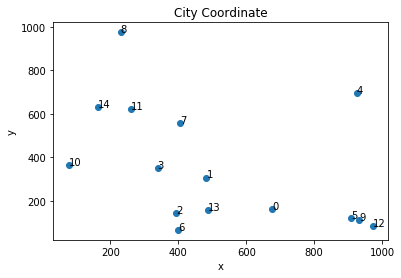

In [4]:
# 点坐标、距离矩阵
coord_generator = CoordinateProcess(num_cities=15, min_coord=1, max_coord=1000)
coord_generator.plot_cities()
city_coord = coord_generator.coordinate
distance_matrix = coord_generator.distance_matrix

best path: [4, 7, 11, 8, 14, 10, 3, 1, 2, 6, 13, 0, 5, 9, 12, 4]
length of best path: 3597.640096722556
best path fitness: 0.027795998852442143


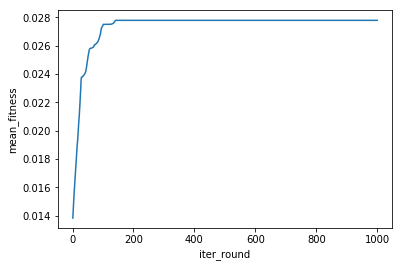

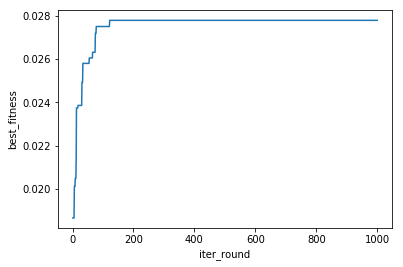

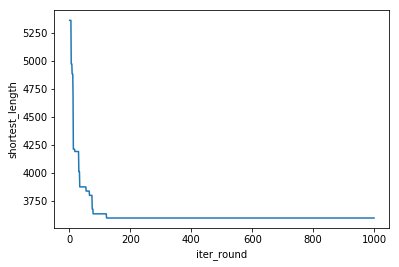

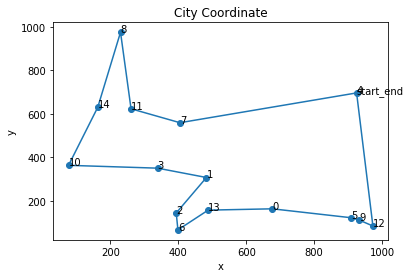

(None, None)

In [5]:
# 遗传算法
test_genetic = GeneticTsp(city_coord, distance_matrix,chrmsome_size=100,cross_prob=0.6,mutate_prob=0.6,iter_round=1000,
                 mutate_percentage=0.2)
test_genetic.ga_engine()